In [1]:
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import os
# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test, mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
#     print(features)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    return features

def clean_sentence(output):
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = data_loader.dataset.vocab.idx2word[idx]
        sentence = sentence + word + ' '
        
    return sentence

def fetch_image(file_name):
    orig_image = Image.open(file_name).convert('RGB')
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    transform_test = transforms.Compose([ 
        transforms.Resize(256),                          
        transforms.CenterCrop(224),                             
        transforms.ToTensor(),                           
        transforms.Normalize((0.485, 0.456, 0.406),      
                             (0.229, 0.224, 0.225))])
    input_image = transform_test(orig_image)
    return orig_image, input_image

def generate_caption(input_image,encoder):
    print(input_image.shape)
    features = encoder(input_image).unsqueeze(1)
    features.to(device)
#     print(features.shape)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


INITIALIZING THE INPUT

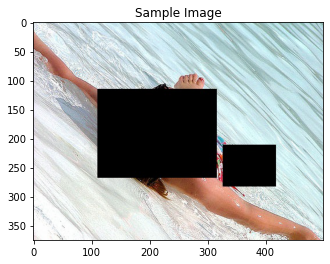

In [4]:
file_name = 'child_adverserial.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)

IMPORTING THE MODEL

In [5]:
%load_ext autoreload
%autoreload 2

import os
import torch
from model_tree_saliency import EncoderCNN_b ,DecoderRNN_b

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN_b(embed_size)
encoder.eval()
decoder = DecoderRNN_b(embed_size, hidden_size, vocab_size)
decoder.eval()
print(os.getcwd())
address = os.path.join(os.getcwd(),'models', encoder_file)
print(address)
# Load the trained weights.
encoder.load_state_dict(torch.load(address))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file)))

# Move models to GPU if CUDA is available.      
encoder.to(device)
decoder.to(device)
# encoder.zero_grad()
# decoder.zero_grad()

# print(clean_sentence(caption))
from lstm_saliency_tree import Saliency

target_layer = [*encoder.children()][0][-2][0].conv1
saliency_object = Saliency(encoder,decoder,target_layer)
cap_sal_dict = saliency_object(input_image.reshape(1,3,224,224).to('cuda'))

Vocabulary successfully loaded from vocab.pkl file!
9 2048
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning\models\encoder-1.pkl
Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [6]:
from utils import visualize_cam
from datetime import datetime
## function to generate the captions for all the timestamps
def create_saliency_map(caption,saliency_maps):
    images_=[]
    for saliency_map in saliency_maps:
        saliency_map.cpu()
        heatmap_t, result_t = visualize_cam(saliency_map.cpu(),input_image.cpu())
        images_.append(torch.stack([input_image.squeeze().cpu(),heatmap_t,result_t],0))
    images = make_grid(torch.cat(images_,0),nrow=3)
    
    output_dir = 'outputs'
    os.makedirs(output_dir, exist_ok=True)
    now = datetime.now()
    dt_string = now.strftime("%H_%M_%S")
    output_name = caption.replace(" ", "_") + dt_string + "_lstm_output.JPEG"
    output_path = os.path.join(output_dir, output_name)
    save_image(images, output_path)

In [7]:
for keys in cap_sal_dict:
    create_saliency_map(keys,cap_sal_dict[keys])
    print(keys)

a man with a beard and a black shirt and a black tie . 
a man with a beard and a black shirt and black tie . 
a man with a beard is sitting on a couch . 
a man with a beard is sitting on a chair . 
a man with a beard is sitting on a bed . 
a man in a suit and tie sitting on a chair . 


ADDING ALL THE SALIENCY MAPS GENERATED FOR ONE CAPTION

In [22]:
print(keys)
saliency_maps = cap_sal_dict[keys]
result = torch.zeros([1,1,224,224]).to(device)
# print(result)
images = []
for s_map in saliency_maps:
#     s_map = s_map/len(keys.split())
    result = result + s_map
# result = result/len(keys.split())
heatmap_t, result_t = visualize_cam(result.cpu(),input_image.cpu())
added_image = torch.stack([input_image.squeeze().cpu(),heatmap_t,result_t],0)
images.append(added_image)
# print(added_image.size())
images_ = make_grid(torch.cat(images,0),nrow=3)
output_name =  keys.replace(" ", "_")+file_name
save_image(images_, os.path.join("outputs", output_name))

a surfer is riding a wave in the ocean . 


tensor([2, 4])
